# Using Second-Order Monochromator Transmission for Calibration

In [3]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
import scipy

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData
# reload(PTI.SpectraFitting)
import PTI.SpectraFitting as spec_fit

In [4]:
'''Interpolates between two points by taking the average of them. Returns an array twice the size'''
def interpolate_with_avg(array):
    return np.append(np.dstack((array[:-1], array[:-1] + np.diff(array)/2)).ravel(), array[-1])

# Import emission correction files
emcorr_quanta_sphere_wavelengths = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                                 skip_header = 6,
                                                 usecols = 0,
                                                 max_rows = (848-300)/2 +1)
emcorr_quanta_sphere_values = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                            skip_header = 6,
                                            usecols = 1,
                                            max_rows = (848-300)/2 +1)

emcorr_quanta_sphere_wavelengths = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_wavelengths))
emcorr_quanta_sphere_values = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_values))


start_wavelength = 300
end_wavelength = 650
desired_wavelengths = np.where((emcorr_quanta_sphere_wavelengths >= start_wavelength) & 
                               (emcorr_quanta_sphere_wavelengths <= end_wavelength))

emcorr_quanta_sphere_values = emcorr_quanta_sphere_values[desired_wavelengths]

We first need to find emission scans blank samples where we excite at some $\lambda_0$ and scan through some interval $I_{em}=[\lambda_i, \lambda_f]$ such that $2\lambda_0\in I_{em}$. As it turns out, the only samples that fit this criterion are the ethanol-only scans taken in August 2016 and June 2017.

In [5]:
blank_data_paths = ["Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex310_2sec_160830.txt",
                    "Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex320_2sec_160830.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_Empty_em310_ex300-650_0x5nm_2sec_20170614_1659.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20160619.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_empty_ex310_em300-650_2sec_20170621.txt"
                   ]

ex = [310,320,310,310,310,310]

blank_data = list()
for path in blank_data_paths:
    blank_data.append(PTIData(path))
    
corrected_data = list()
for data_set in blank_data:
    baseline = spec_fit.get_linear_subtracted(data_set, 1, [[400,600]])
    emcorr = np.multiply(baseline, emcorr_quanta_sphere_values)
    copy = deepcopy(data_set)
    copy.cor_data = emcorr
    corrected_data.append(copy)
    

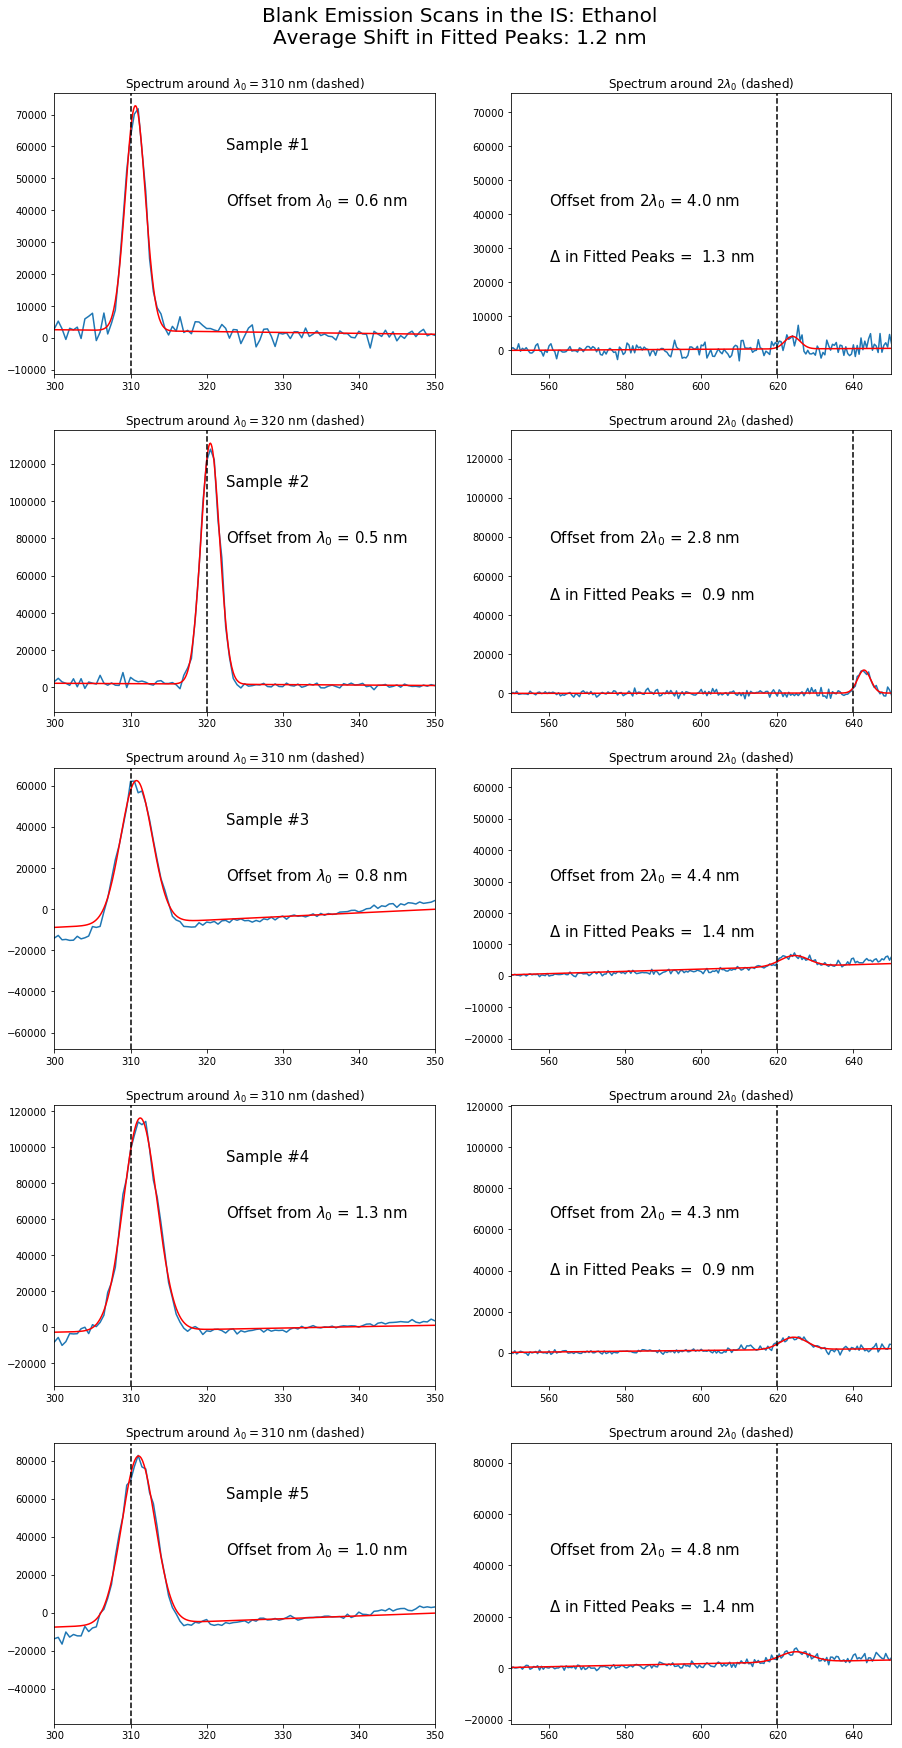

In [21]:
num_subplots = len(corrected_data)
fig = plt.figure(figsize = (15,30))

x = np.arange(0, 650, 0.1)
fir_ord_range = [[300,400]]
sec_ord_range = [[500,650]]

shifts = list()
for i in range(0,2*num_subplots,2):
    
    ## Left Graph ##
    peak = np.max(corrected_data[i/2].cor_data)
    gauss_params = spec_fit.gaussian_linear_fit(corrected_data[i/2], fir_ord_range, 
                                                (peak, 1.0, ex[i/2], 1.0,1.0))
    fir_ord_center = gauss_params[2]
    gauss_graph = spec_fit.gaussian_linear_func(x, gauss_params)
    
    ax1 = fig.add_subplot(num_subplots, 2, i+1)
    ax1.plot(corrected_data[i/2].wavelengths, corrected_data[i/2].cor_data)
    ax1.plot(x, gauss_graph,'r')
    ax1.set_xlim([300,350])
    ax1.axvline(x=ex[i/2], ymax=1, color='k', linestyle='--')
    ax1.set_title(r'Spectrum around $\lambda_0 = $%d nm (dashed)'%ex[i/2])
    ax1.text(0.45, 0.8,"Sample #" + str(i/2 +1),transform=ax1.transAxes,fontsize = 15)
    ax1.text(0.45, 0.6,r"Offset from $\lambda_0$ = %0.1f nm" %(fir_ord_center-ex[i/2]),transform=ax1.transAxes,fontsize = 15)
    
    ## Right Graph ##
    peak = np.max(corrected_data[i/2].cor_data)
    gauss_params = spec_fit.gaussian_linear_fit(corrected_data[i/2], sec_ord_range, 
                                                (peak, 1.0, 2*ex[i/2], 1.0,1.0))
    sec_ord_center = gauss_params[2]
    gauss_graph = spec_fit.gaussian_linear_func(x, gauss_params)
    
    ax2 = fig.add_subplot(num_subplots, 2, i+2)
    ax2.plot(corrected_data[i/2].wavelengths, corrected_data[i/2].cor_data)
    ax2.plot(x, gauss_graph,'r')
    ax2.set_xlim([550,650])
    ax2.axvline(x=2*ex[i/2], ymax=1, color='k', linestyle='--')
    ax2.set_title(r'Spectrum around $2\lambda_0$ (dashed)')
    
    ax2.text(0.1, 0.6,r"Offset from $2\lambda_0$ = %0.1f nm" %(sec_ord_center-2*ex[i/2]),transform=ax2.transAxes,fontsize = 15)
    peak_shift = 0.5*sec_ord_center - fir_ord_center
    shifts.append(peak_shift)
    ax2.text(0.1, 0.4,r"$\Delta$ in Fitted Peaks =  %.1f nm" %peak_shift, transform=ax2.transAxes,fontsize = 15)

                 
plt.suptitle("Blank Emission Scans in the IS: Ethanol"+
             "\nAverage Shift in Fitted Peaks: %.1f nm" %np.mean(shifts), y=.92, fontsize=20)   
plt.show()

**Preliminary results**: 

It appears that the secondary excitation peak appears at a larger wavelength that expected. Although it is difficult to tell when the first peak excitation peak is also off-center, Samples #1 through #3 provide evidence supporting the shift. In these samples, the incoming light has a first peak about $\lambda_0$, but the secondary peak is further left than $2\lambda_0$. 

No mention of such a shift is mentioned in *Principles of Fluorescent Spectroscopy*. More insight into the calibration of the monochromators is needed. It is possible that this analysis could allow the secondary peak to be used for calibration. 